## Explore and Calculate Metrics

Here we calculate metrics for final post-processed boxes and can look at how those metrics change with other steps in the post processing, if you want to.

In [231]:
# # How well does our model do on non-commericial PubLayNet pages?
# # for benchmarks,ioustar defaults to 0.6 or 0.9
benchmark = True
ioubench = 0.9
use_cv = False

plot_post_proc = True # plot post processing steps?

# for new stuff
metric_results_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/htrc/'
images_jpeg_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/Pages_htrc/RandomSingleFromPDFIndexed/'
image_save_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/paper3_htrc/figures/'

# for paper 1/2
metric_results_dir_old = '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/'
images_jpeg_dir_old = '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Pages/RandomSingleFromPDFIndexed/'
binary_dirs_old = 'binaries_model12_finaltest/'

store_diagnostics = False # set to False or None if you don't want to


# -----------------------------------------------------
# less toggled options

use_cv = False # CV for error bars, generally set to False for small datasets
seed = 5 # set seed for CV -- good if you wanna compare things

# do we want to store any diagnostic plots (this will slow things down)
save_no_post_proc = False # also save w/o post processing, generally set to False here

binary_dirs = 'binaries/'
detectron2_file = 'detectron2'

use_valid = False
use_train = False

In [232]:
if images_jpeg_dir is None: 
    images_jpeg_dir = config.images_jpeg_dir
# do we want to save our results to .dat files for use in other areas (like tables in latex)
save_dats = True
#any extra tag to anything
adder_dats = ''
# which iou's to save?
#ioustar = [0.9,0.95] # fig, caption
#ioustar = [0.1,0.6,0.9] # fig, caption
scorestar = 0.1

if benchmark: ioustar = [ioubench]

adder = ''
#adder = 'colorbar'
#adder = 'truebox'

if use_valid: adder = '_valid'
if use_train: adder = '_train'

How do we want to quantify how well we are doing?

In [233]:
n_folds_cv = 5 # for calculating the spread in our metrics, we we'll do a CV
#####if not use_cv: n_folds_cv = 1
scoreminVec = [0.1, 0.5, 0.9] # list of minimum box "scores"
iouminVec = [0.1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95] # list of IOU cut offs we want to explore

In [234]:
import pickle
import config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from PIL import Image
import cv2 as cv
from metric_utils import calc_base_metrics_allboxes_cv, calc_prec_rec_f1_cv, print_metrics_table, \
  get_years_dataframe, calc_AP
from general_utils import create_destroy_dirs

In [235]:
diagnostics_dir = config.tmp_storage_dir
if store_diagnostics is None: store_diagnostics = config.store_diagnostics
    
if store_diagnostics:
    for d in ['FN/','FP/','TP/']:
        create_destroy_dirs(diagnostics_dir+d)

In [236]:
# # debugging
# import metric_utils
# reload(metric_utils)
# from metric_utils import calc_base_metrics_allboxes_cv,calc_metrics

In [237]:
# build up filename
if metric_results_dir is None:
    pp = config.metric_results_dir
else:
    pp = metric_results_dir
pp += binary_dirs.split('/')[0]
pp += adder
pp += '.pickle'
with open(pp, 'rb') as ff:
    icombo,imgs_name, truebox, pdfboxes, pdfrawboxes, captionText_figcap,\
                 bbox_figcap_pars,\
                 sboxes_cleaned, slabels_cleaned, sscores_cleaned,\
                 boxes_pdf, labels_pdf, scores_pdf,\
                 boxes_heur, labels_heur, scores_heur,\
                 boxes_heur2, labels_heur2, scores_heur2,\
                 boxes_par_found, labels_par_found, scores_par_found,\
                 boxes_sq1, labels_sq1, scores_sq1,\
                 boxes_sq2, labels_sq2, scores_sq2,\
                 boxes_sq3, labels_sq3, scores_sq3,\
                 boxes_sq4, labels_sq4, scores_sq4,\
                 boxes_sq5, labels_sq5, scores_sq5,\
                 truebox1,truebox2,truebox3,rotatedImage,LABELS,boxes1, scores1, labels1 = pickle.load(ff)
    
# also get detectron2 boxes
pp2 = metric_results_dir + detectron2_file + '.pickle'
with open(pp2,'rb') as ff:
    img_names_fb, boxes_fb, scores_fb, classes_fb, other_classes, height,width = pickle.load(ff)
    

# also, for old stuff -- ours
pp = metric_results_dir_old
pp += binary_dirs_old.split('/')[0]
#pp += adder
pp += '.pickle'
with open(pp, 'rb') as ff:
    icombo_ours,imgs_name_ours, truebox_ours, pdfboxes_ours, pdfrawboxes_ours, captionText_figcap_ours,\
                 bbox_figcap_pars_ours,\
                 sboxes_cleaned_ours, slabels_cleaned_ours, sscores_cleaned_ours,\
                 boxes_pdf_ours, labels_pdf_ours, scores_pdf_ours,\
                 boxes_heur_ours, labels_heur_ours, scores_heur_ours,\
                 boxes_heur2_ours, labels_heur2_ours, scores_heur2_ours,\
                 boxes_par_found_ours, labels_par_found_ours, scores_par_found_ours,\
                 boxes_sq1_ours, labels_sq1_ours, scores_sq1_ours,\
                 boxes_sq2_ours, labels_sq2_ours, scores_sq2_ours,\
                 boxes_sq3_ours, labels_sq3_ours, scores_sq3_ours,\
                 boxes_sq4_ours, labels_sq4_ours, scores_sq4_ours,\
                 boxes_sq5_ours, labels_sq5_ours, scores_sq5_ours,\
                 truebox1_ours,truebox2_ours,truebox3_ours,rotatedImage_ours,\
    LABELS_ours,boxes1_ours, scores1_ours, labels1_ours = pickle.load(ff)
    
# also, for old stuff -- ours
pp = metric_results_dir_old
pp += binary_dirs_old.split('/')[0]
pp += '_fbdetect'
pp += '.pickle'
with open(pp, 'rb') as ff:
    #img_names_fb_old, boxes_fb_old, scores_fb_old, classes_fb_old, \
    #  other_classes_old, height_old,width_old= pickle.load(ff)
    img_names_fb_old,boxes_fb_old,classes_fb_old,\
      scores_fb_old,height_old,width_old = pickle.load(ff)

In [238]:
# align name with year -- make up for the fact we messed up a few :P

name_year = {'uiug-30112101602172-1666102417':1963, 'osu-32435023323769-1666273876':1985}
imgs_name_year = []; img_names_fb_year = []
for im in imgs_name:
    i = im.split('/')[-1].split('_p')[0]
    if i in name_year:
        imgs_name_year.append(name_year[i])
    elif i[:4].isdigit():
        imgs_name_year.append(int(i[:4]))
    else:
        print('NO IDEA')
        import sys; sys.exit()
# and detectron2
for im in img_names_fb:
    i = im.split('/')[-1].split('_p')[0]
    if i in name_year:
        img_names_fb_year.append(name_year[i])
    elif i[:4].isdigit():
        img_names_fb_year.append(int(i[:4]))
    else:
        print('NO IDEA')
        import sys; sys.exit()

In [239]:
#imgs_name_year

In [240]:
#config.metric_results_dir

Final box analytics:

In [241]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv,
                                                         seed=seed)

In [242]:
TPv.shape

(4, 3, 8, 5)

Shape is: (# labels, #scores, #ious, #CV folds)

Calculate precision, recall, F1 (ignore /0 warnings, taken care of):

In [243]:
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouminVec)

Plot and check it out!

/var/folders/t7/bwcvd_4177q4872gxghn7p9r0000gq/T/ipykernel_25926/2364860595.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(ps, labels=LABELS)


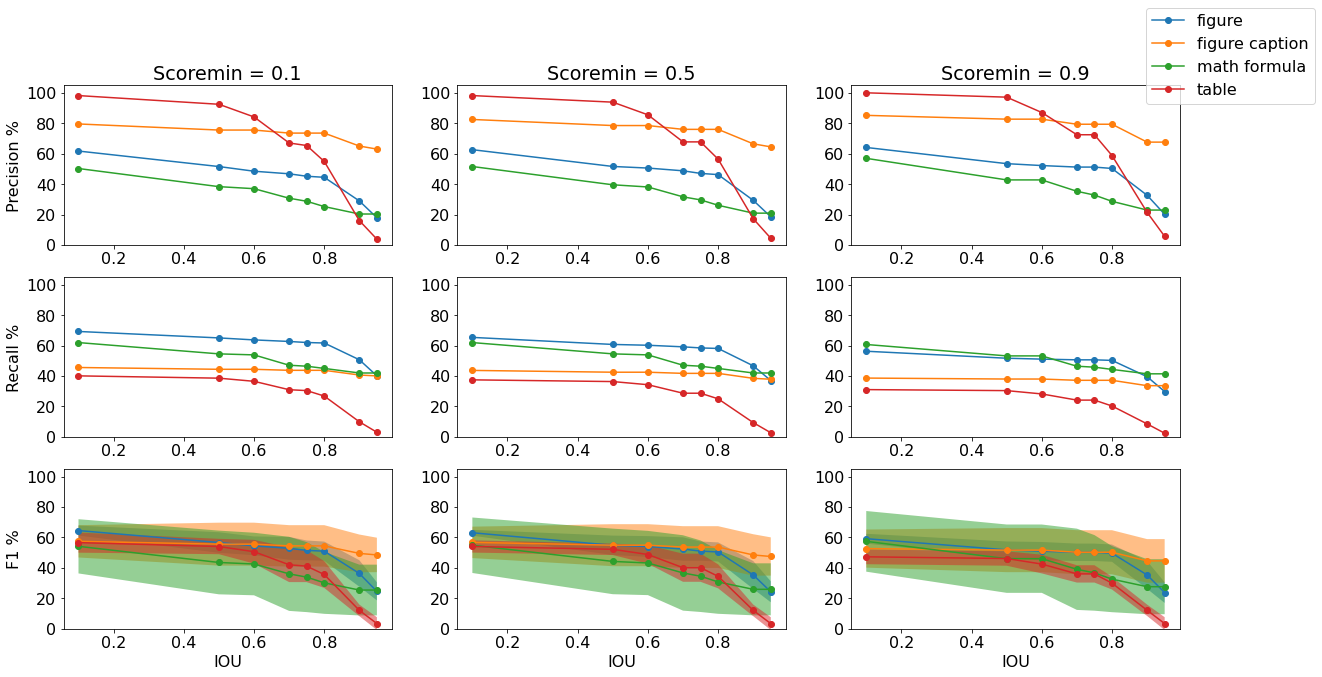

In [244]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Detectron2

First, make dataframe:

In [245]:
other_classes

['text', 'title', 'list', 'table', 'figure']

In [246]:
inames2 = []; bfb = []; cfb = []; scs = []; alltext = []
for im,b,c,s,h,w in zip(img_names_fb,boxes_fb,classes_fb,scores_fb,height,width):
    xx = np.array(b)
    #if len(xx) > 0:
    #    xx = xx.reshape(xx.shape[0],xx.shape[2])
    #else:
    #    xx = np.array([])
    inames2.append(im.split('/')[-1].split('.jpeg')[0])
    cc = np.array(c).flatten()
    cc2 = []; x22 = []; sc = []; att = []
    for x,ccc,ss in zip(xx,cc,s): # loop and re-index
        x1 = x[0]/w*config.IMAGE_W
        y1 = x[1]/h*config.IMAGE_H
        x2 = x[2]/w*config.IMAGE_W
        y2 = x[3]/h*config.IMAGE_H
        if other_classes[ccc] == 'figure':
            cc2.append(LABELS.index('figure'))
            x22.append(np.array([x1,y1,x2,y2]))
            sc.append(ss.flatten()[0])
        elif other_classes[ccc] == 'text':
            att.append(np.array([x1,y1,x2,y2]))
        elif other_classes[ccc] == 'table':
            cc2.append(LABELS.index('table'))
            x22.append(np.array([x1,y1,x2,y2]))
            sc.append(ss.flatten()[0])
            
            
    # loop and find possible fig caption
    caps = []; caps_box = []; cap_s = []
    x23 = []
    for figb in x22:
        capd = 1e20; iind = -1
        for ii,(x,ccc,ss) in enumerate(zip(xx,cc,s)): # loop and re-index    
            if other_classes[ccc] == 'text':
                x1 = x[0]/w*config.IMAGE_W
                y1 = x[1]/h*config.IMAGE_H
                x2 = x[2]/w*config.IMAGE_W
                y2 = x[3]/h*config.IMAGE_H   
                xc = 0.5*(x1+x2); yc = 0.5*(y2+y1)
                #xf = 0.5*(figb[0]+figb[2]); yf = 0.5*(figb[1]+figb[3])
                # closest to center
                #xf = 0.5*(figb[0]+figb[2]); yf = figb[3]
                xf = 0.5*(figb[0]+figb[2]); yf = (figb[1]+figb[3])*0.5
                d = np.sqrt( (xc-xf)**2 + (yc-yf)**2 )
                if d < capd:
                    iind = ii
                    capd = d
                    
        xarr = np.array(xx[iind])
        x23.append(np.array([xarr[0]/w*config.IMAGE_W,xarr[1]/h*config.IMAGE_H, 
                             xarr[2]/w*config.IMAGE_W,xarr[3]/h*config.IMAGE_H]))
        sc.append(np.array(s).flatten()[iind])
        cc2.append(LABELS.index('figure caption'))
                   
        #import sys; sys.exit()      
            
    #import sys; sys.exit()
    x22.extend(x23)
            
    bfb.append(x22)
    cfb.append(cc2)
    scs.append(sc)
    alltext.append(att)
        
df1 = pd.DataFrame({'name':inames2, 'found_fb':bfb, 'classes_fb':cfb, 'scores_fb':scs, 'alltext':alltext})

In [247]:
other_classes

['text', 'title', 'list', 'table', 'figure']

In [271]:
len(dfall)

363

Now make our model dataframe:

In [248]:
inames1 = []
for im in imgs_name:
    inames1.append(im.split('/')[-1].split('.npz')[0])
    
df2 = pd.DataFrame({'name':inames1, 'found':boxes_sq5, 'classes':labels_sq5, 'true':truebox1, 
                   'true_pp':truebox3})
# for true, use the less processed ones like truebox1 or truebox2 -- choose the best, probably the least processed which is truebox1

In [249]:
#df2

Put it all together and what do you get?

In [250]:
dfall = df1.set_index('name').join(df2.set_index('name'))

In [251]:
dfall.head(n=2)

,found_fb,classes_fb,scores_fb,alltext,found,classes,true,true_pp
name,,,,,,,,
1964_mdp-39015021746196-1666715318_p1,"[[16.09622987689394, 2.6924437934670022, 512.0...","[0, 1]","[0.9511671, 0.9511671]",[],[],[],[],[]
1964_mdp-39015021746196-1666715318_p10,"[[42.576541785037875, 276.52535883397456, 375....","[0, 0, 1, 1]","[0.9698214, 0.82824606, 0.9337609, 0.9755146]","[[381.5087357954545, 171.45636652855873, 486.5...","[(32.38346862792969, 0.3030482391240012, 507.5...",[0],"[[39.0, 273.0, 374.0, 457.0, 1.0], [384.0, 1.0...","[[384.0, 285.0, 449.0, 320.0, 2.0], [39.0, 273..."


In [252]:
# make database for paper 1 results too
inames2 = []; bfb = []; cfb = []; scs = []; alltext = []
for im,b,c,s,h,w in zip(img_names_fb_old,boxes_fb_old,classes_fb_old,scores_fb_old,height_old,width_old):
    xx = np.array(b)
    if len(xx) > 0:
        xx = xx.reshape(xx.shape[0],xx.shape[2])
    else:
        xx = np.array([])    
    inames2.append(im.split('/')[-1].split('.jpeg')[0])
    cc = np.array(c).flatten()
    cc2 = []; x22 = []; sc = []; att = []
    for x,ccc,ss in zip(xx,cc,s): # loop and re-index
        x1 = x[0]/w*config.IMAGE_W
        y1 = x[1]/h*config.IMAGE_H
        x2 = x[2]/w*config.IMAGE_W
        y2 = x[3]/h*config.IMAGE_H
        if other_classes[ccc] == 'figure':
            cc2.append(LABELS.index('figure'))
            x22.append(np.array([x1,y1,x2,y2]))
            sc.append(ss.flatten()[0])
        elif other_classes[ccc] == 'text':
            att.append(np.array([x1,y1,x2,y2]))
        elif other_classes[ccc] == 'table':
            cc2.append(LABELS.index('table'))
            x22.append(np.array([x1,y1,x2,y2]))
            sc.append(ss.flatten()[0])
            
            
    # loop and find possible fig caption
    caps = []; caps_box = []; cap_s = []
    x23 = []
    for figb in x22:
        capd = 1e20; iind = -1
        for ii,(x,ccc,ss) in enumerate(zip(xx,cc,s)): # loop and re-index    
            if other_classes[ccc] == 'text':
                x1 = x[0]/w*config.IMAGE_W
                y1 = x[1]/h*config.IMAGE_H
                x2 = x[2]/w*config.IMAGE_W
                y2 = x[3]/h*config.IMAGE_H   
                xc = 0.5*(x1+x2); yc = 0.5*(y2+y1)
                #xf = 0.5*(figb[0]+figb[2]); yf = 0.5*(figb[1]+figb[3])
                # closest to center
                #xf = 0.5*(figb[0]+figb[2]); yf = figb[3]
                xf = 0.5*(figb[0]+figb[2]); yf = (figb[1]+figb[3])*0.5
                d = np.sqrt( (xc-xf)**2 + (yc-yf)**2 )
                if d < capd:
                    iind = ii
                    capd = d
                    
        xarr = np.array(xx[iind])
        x23.append(np.array([xarr[0]/w*config.IMAGE_W,xarr[1]/h*config.IMAGE_H, 
                             xarr[2]/w*config.IMAGE_W,xarr[3]/h*config.IMAGE_H]))
        sc.append(np.array(s).flatten()[iind])
        cc2.append(LABELS.index('figure caption'))
                   
        #import sys; sys.exit()      
            
    #import sys; sys.exit()
    x22.extend(x23)
            
    bfb.append(x22)
    cfb.append(cc2)
    scs.append(sc)
    alltext.append(att)
        
df1_old = pd.DataFrame({'name':inames2, 'found_fb':bfb, 'classes_fb':cfb, 'scores_fb':scs, 'alltext':alltext})

inames1 = []
for im in imgs_name_ours:
    inames1.append(im.split('/')[-1].split('.npz')[0])
    
df2_old = pd.DataFrame({'name':inames1, 'found':boxes_sq5_ours, 'classes':labels_sq5_ours, 'true':truebox1_ours, 
                   'true_pp':truebox3_ours})

dfall_old = df1_old.set_index('name').join(df2_old.set_index('name'))

In [253]:
trueshere = []
#names_fb = []
for t in np.array(dfall['true'].values).tolist():
    #if len(t) == 0:
    #    if t == np.nan:
    if type(t) != float:
        trueshere.append(t)
    else:
        trueshere.append([])

boxes_fb = dfall['found_fb'].values.tolist(); 
labels_fb = dfall['classes_fb'].values.tolist(); 
scores_fb = dfall['scores_fb'].values.tolist()
names_fb = dfall.index.values.tolist()


TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                              trueshere,boxes_fb,labels_fb, 
                                              scores_fb,n_folds_cv=n_folds_cv,
                                                         seed=seed)

In [254]:
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouminVec)

/var/folders/t7/bwcvd_4177q4872gxghn7p9r0000gq/T/ipykernel_25926/2364860595.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(ps, labels=LABELS)


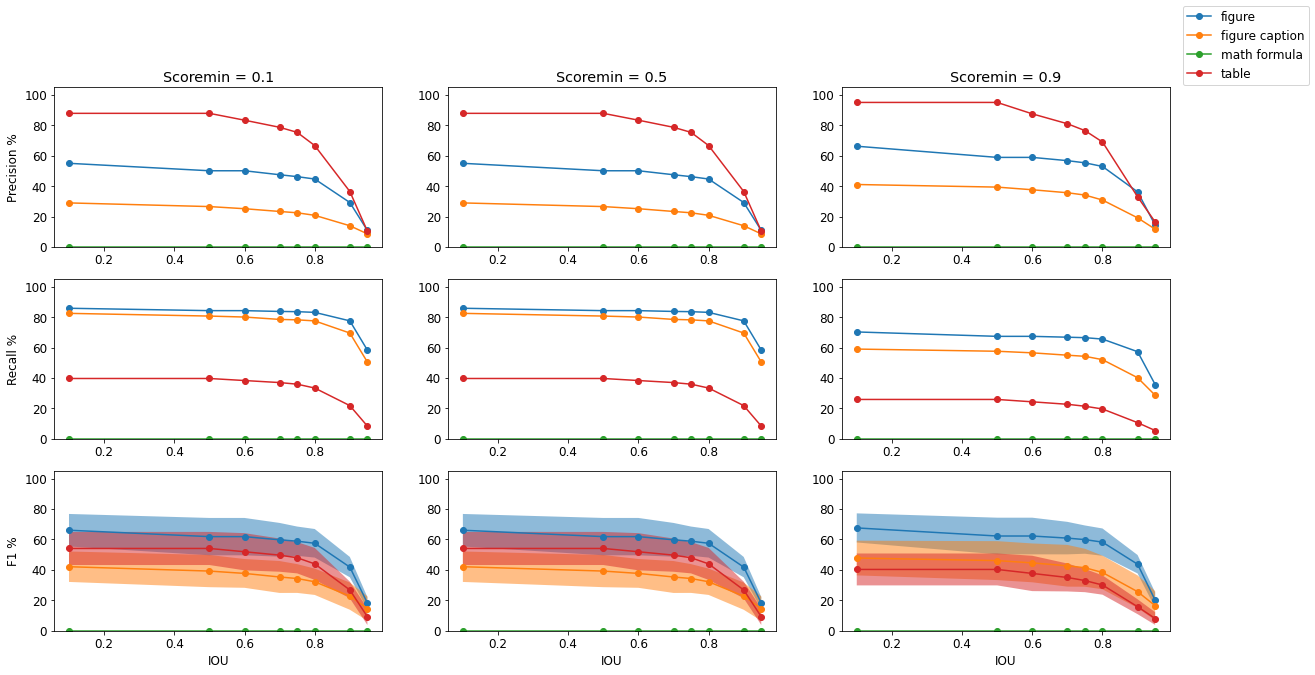

In [255]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Comparisions!

Let's do some calculations for the different articles:

In [256]:
scoremin = 0.1 # typically fine
ioumin_per_label = [0.8, 0.8, 0.8, 0.8] # fig, fig+caption, math formula, table

In [257]:
from importlib import reload
import metric_utils
from metric_utils import print_metrics_table

Ours:

In [258]:
TP,FP,FN,precision, precision_std, \
  recall, recall_std,f1,f1_std,aps = print_metrics_table(LABELS,
                                                         [scoremin],
                                                         ioumin_per_label,
                        truebox3,boxes_sq5,labels_sq5, 
                        scores_sq5)

SCORE =  0.1  N_CV =  1
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       112             95              69              108            
--------------------------------------------------------------------------------------------
TP              48.2%           37.9%           33.3%           22.2%          
FP              58.9%           13.7%           72.5%           19.4%          
FN              31.2%           53.7%           26.1%           59.3%          
--------------------------------------------------------------------------------------------
Precision       45.0+/-0.0%     73.5+/-0.0%     31.5+/-0.0%     53.3+/-0.0%    
Recall          60.7+/-0.0%     41.4+/-0.0%     56.1+/-0.0%     27.3+/-0.0%    
F1              51.7+/-0.0%     52.9+/-0.0%     40.4+/-0.0%     36.1+/-0.0%    


In [259]:
TP,FP,FN,precision, precision_std, \
  recall, recall_std,f1,f1_std,aps = print_metrics_table(LABELS,
                                                         [scoremin],
                                                         ioumin_per_label,
                        trueshere,boxes_fb,labels_fb, 
                                              scores_fb)

SCORE =  0.1  N_CV =  1
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       112             96              69              108            
--------------------------------------------------------------------------------------------
TP              67.9%           47.9%           0.0%            30.6%          
FP              83.9%           181.2%          0.0%            15.7%          
FN              13.4%           13.5%           100.0%          59.3%          
--------------------------------------------------------------------------------------------
Precision       44.7+/-0.0%     20.9+/-0.0%     0.0+/-0.0%      66.0+/-0.0%    
Recall          83.5+/-0.0%     78.0+/-0.0%     0.0+/-0.0%      34.0+/-0.0%    
F1              58.2+/-0.0%     33.0+/-0.0%     0.0+/-0.0%      44.9+/-0.0%    


Do the table for each of the PDFs:

In [260]:
pdfs = []
for i in imgs_name:
    im = i.split('/')[-1].split('_p')[0]
    pdfs.append(im)
pdfs = np.unique(pdfs)
#pdfs

In [261]:
# print('-------------- OURS --------------')
# for p in pdfs:
#     print(p)
#     t,b,l,s = [],[],[],[]
#     for i,tt,bb,ll,ss in zip(imgs_name,truebox3,boxes_sq5,labels_sq5,scores_sq5): # not elegant!
#         if p in i:
#             t.append(tt);b.append(bb);l.append(ll);
#             s.append(ss)

#     TP,FP,FN,precision, precision_std, \
#       recall, recall_std,f1,f1_std,aps = print_metrics_table(LABELS,
#                                                              [scoremin],
#                                                              ioumin_per_label,
#                             t,b,l,s)
#     print(' ')
    
# print(' ')
# print('-------------- detectron2 --------------')
# print(' ')
# for p in pdfs:
#     print(p)
#     t,b,l,s = [],[],[],[]
#     for i,tt,bb,ll,ss in zip(names_fb,trueshere,boxes_fb,labels_fb, 
#                                               scores_fb): # not elegant!
#         if p in i:
#             t.append(tt);b.append(bb);l.append(ll);
#             s.append(ss)

#     TP,FP,FN,precision, precision_std, \
#       recall, recall_std,f1,f1_std,aps = print_metrics_table(LABELS,
#                                                              [scoremin],
#                                                              ioumin_per_label,
#                             t,b,l,s)
#     print(' ')

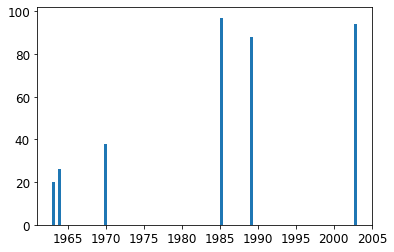

In [262]:
plt.hist(img_names_fb_year,bins=100)
plt.show()

Save all found/true boxes as diagnostics if requested:

In [263]:
#images_jpeg_dir

In [264]:
iouDiag = 0.8
uptoInd = 2 # only figs, fig captions

# what about other post-processing steps? set to empty list to not use
# truebox, found box, labels found, colors true, colors found
#other_steps = [[truebox1, boxes_sq1, labels_sq1, (0,255,0),(100,255,0)]]
other_steps = []
drawTrueOther = False # set to false to ignore true in drawing each step

if store_diagnostics:
    # ours
    print('----------- OURS --------------')
    for ic,(iname,tb,fb,lb,sb) in enumerate(zip(imgs_name,truebox3,boxes_sq5,labels_sq5,scores_sq5)):
        if ic%50 == 0: print('on', ic, 'of', len(imgs_name))
        TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[iouDiag],
                                                  [tb],[fb],[lb], [sb],n_folds_cv=1)
        iiname = images_jpeg_dir+iname.split('/')[-1].rstrip('.npz')+'.jpeg'
        img = np.array(Image.open(iiname).convert('RGB'))
        xfrac = img.shape[1]/config.IMAGE_W
        yfrac = img.shape[0]/config.IMAGE_H
        for met,metdir in zip([TPs, FPs, FNs],['TP','FP','FN']): # loop over all metrics
            if np.sum(met[:uptoInd].flatten()) > 0: # have at least one hit
                for bb in tb: # draw true
                    if bb[-1] < uptoInd+1: # only for select ones
                        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                        cv.rectangle(img, (round(xmin), round(ymin)), 
                                     (round(xmax),round(ymax)), (0,0,255), 5)
                for bb,ll in zip(fb,lb): # draw found
                    if ll <uptoInd:
                        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                        cv.rectangle(img, (round(xmin), round(ymin)), 
                                     (round(xmax),round(ymax)), (255,0,0), 5)
                        
                # other boxes if requested
                if len(other_steps)>0:
                    for tb3,bb3,ll3,cc2t,cc2f in other_steps:
                        tb2,bb2,ll2 = tb3[ic],bb3[ic],ll3[ic]
                        if drawTrueOther:
                            for bb in tb2: # draw true
                                if bb[-1] < uptoInd+1: # only for select ones
                                    xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                                    ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                                    cv.rectangle(img, (round(xmin), round(ymin)), 
                                                 (round(xmax),round(ymax)), cc2t, 5)
                        for bb,ll in zip(bb2,ll2): # draw found
                            if ll <uptoInd:
                                xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                                ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                                cv.rectangle(img, (round(xmin), round(ymin)), 
                                             (round(xmax),round(ymax)), cc2f, 5)

                # save
                Image.fromarray(img).save(diagnostics_dir+metdir+'/'+ iname.split('/')[-1].rstrip('.npz')+'.jpeg')
    # detectron2
    print('----------- detectron2 --------------')
    for ic,(iname,tb,fb,lb,sb) in enumerate(zip(img_names_fb,trueshere,boxes_fb,labels_fb, 
                                              scores_fb)):
        if ic%50 == 0: print('on', ic, 'of', len(img_names_fb))
        TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[iouDiag],
                                                  [tb],[fb],[lb], [sb],n_folds_cv=1)
        #iiname = images_jpeg_dir+iname.split('/')[-1].rstrip('.npz')+'.jpeg'
        iiname = iname
        img = np.array(Image.open(iiname).convert('RGB'))
        xfrac = img.shape[1]/config.IMAGE_W
        yfrac = img.shape[0]/config.IMAGE_H
        for met,metdir in zip([TPs, FPs, FNs],['TPd2','FPd2','FNd2']): # loop over all metrics
            if np.sum(met[:uptoInd].flatten()) > 0: # have at least one hit
                # if '1964' in iiname and 'p16' in iiname:
                #     print(metdir)
                
                for bb in tb: # draw true
                    if bb[-1] < uptoInd+1: # only for select ones
                        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                        cv.rectangle(img, (round(xmin), round(ymin)), 
                                     (round(xmax),round(ymax)), (0,0,255), 5)
                for bb,ll in zip(fb,lb): # draw found
                    if ll <uptoInd:
                        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                        cv.rectangle(img, (round(xmin), round(ymin)), 
                                     (round(xmax),round(ymax)), (255,0,0), 5)
                        
                # other boxes if requested
                if len(other_steps)>0:
                    for tb3,bb3,ll3,cc2t,cc2f in other_steps:
                        tb2,bb2,ll2 = tb3[ic],bb3[ic],ll3[ic]
                        if drawTrueOther:
                            for bb in tb2: # draw true
                                if bb[-1] < uptoInd+1: # only for select ones
                                    xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                                    ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                                    cv.rectangle(img, (round(xmin), round(ymin)), 
                                                 (round(xmax),round(ymax)), cc2t, 5)
                        for bb,ll in zip(bb2,ll2): # draw found
                            if ll <uptoInd:
                                xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                                ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                                cv.rectangle(img, (round(xmin), round(ymin)), 
                                             (round(xmax),round(ymax)), cc2f, 5)

                # save
                Image.fromarray(img).save(diagnostics_dir+metdir+'/'+ iname.split('/')[-1].rstrip('.npz').rstrip('.jpeg')+'.jpeg')
        # if '1964' in iiname and 'p16' in iiname:
        #     import sys; sys.exit()


Precision, Recall, F1 in comparision between ours & detectron2:

In [265]:
nsteps = 1000
iouminVec_here = np.linspace(0.1,0.99, nsteps)

sminvec = [0.1]

TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,sminvec,iouminVec_here,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv,
                                                         seed=seed)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,sminvec,
                                               iouminVec_here)

TPvd2, FPvd2, FNvd2, totalTruevd2 = calc_base_metrics_allboxes_cv(LABELS,sminvec,iouminVec_here,
                                              trueshere,boxes_fb,labels_fb, 
                                              scores_fb,n_folds_cv=n_folds_cv,
                                                         seed=seed)
precisiond2, precision_stdd2, recalld2, \
  recall_stdd2, f1d2, f1_stdd2 = calc_prec_rec_f1_cv(TPvd2,FPvd2,FNvd2,
                                               LABELS,sminvec,
                                               iouminVec_here)

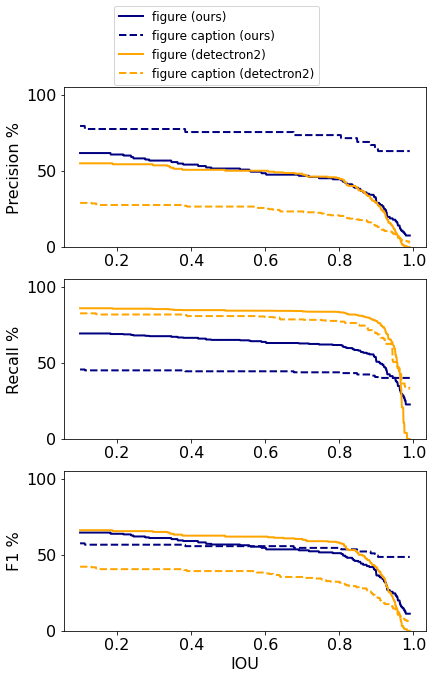

In [266]:
label_up_to = 2

# figs (ours), caps (ours), figs (d2), caps (d2)
colors = ['navy','navy','orange', 'orange'] 
lines = ['-', '--', '-', '--']
lthick = 2

matplotlib.rcParams.update({'font.size': 16})

if len(sminvec) == 1:
    fig, ax = plt.subplots(3,len(sminvec),  figsize=(6.5,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(sminvec),  figsize=(20,10))

#ps = []
# OURS
for i in range(len(sminvec)):
    for k in range(len(LABELS[:label_up_to])): 
        if i==0:
            p1, = ax[0][i].plot(iouminVec_here,precision[k,i,:],lines[k],label=LABELS[k]+' (ours)', 
                                color=colors[k],linewidth=lthick)
        else:
            ax[0][i].plot(iouminVec_here,precision[k,i,:],lines[k],color=colors[k],linewidth=lthick)

        #if i ==0: ps.append(p1)
    #ax[0][i].set_title('Scoremin = '+str(sminvec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS[:label_up_to])): ax[1][i].plot(iouminVec_here,recall[k,i,:], 
                                                             lines[k],color=colors[k],linewidth=lthick)
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS[:label_up_to])): 
        ax[2][i].plot(iouminVec_here,f1[k,i,:], lines[k],color=colors[k],linewidth=lthick)
        # include stddev
        #ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
        
        
# detectron2
for i in range(len(sminvec)):
    for k in range(len(LABELS[:label_up_to])): 
        if i==0:
            p1, = ax[0][i].plot(iouminVec_here,precisiond2[k,i,:],lines[k],
                                label=LABELS[k]+' (detectron2)',
                                color=colors[k+label_up_to],linewidth=lthick)
        else:
            ax[0][i].plot(iouminVec_here,precisiond2[k,i,:],lines[k],
                          color=colors[k+label_up_to],linewidth=lthick)

        #if i ==0: ps.append(p1)
    # ax[0][i].set_title('Scoremin = '+str(sminvec[i]))
    # ax[0][0].set_ylabel('Precision %')
    # ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS[:label_up_to])): ax[1][i].plot(iouminVec_here,recalld2[k,i,:], 
                                                             lines[k],color=colors[k+label_up_to],linewidth=lthick)
    #ax[1][0].set_ylabel('Recall %')
    #ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS[:label_up_to])): 
        ax[2][i].plot(iouminVec_here,f1d2[k,i,:], lines[k],color=colors[k+label_up_to],linewidth=lthick)

# final touches
for i in range(len(sminvec)):
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(loc='upper center',prop={'size': 12})#, labels=LABELS)
#fig.tight_layout()
plt.show()

fig.savefig(image_save_dir+'metrics.pdf')

In [267]:
dfall.columns

Index(['found_fb', 'classes_fb', 'scores_fb', 'alltext', 'found', 'classes',
       'true', 'true_pp'],
      dtype='object')

In [268]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [ ]:
# possible list for qualitative plots:
qplot_new = '1964_mdp-39015021746196-1666715318_p16'
# 1909ApJ____29___55F_p13.jpeg
# 1942ApJ____96__309K_p0.jpeg
# 1944ApJ____99___89S_p7.jpeg # maybe this
# 1954AJ_____59__273S_p3.jpeg # or this
# 1964ApJ___140__292G_p5.jpeg
# 1968ApJ___152___77E_p4.jpeg
# 1974ApJS___28__115S_p0.jpeg
# 1979AJ_____84__538G_p7.jpeg
# 1979ApJ___234__485M_p1.jpeg
# 1980AJ_____85_1207V_p9.jpeg # or maybe
# 1982AJ_____87__849D_p8.jpeg # als maybe
# 1984AJ_____89__630S_p3.jpeg # also nice
# 1991AJ____102__716S_p4.jpeg
# 1991ApJ___370__130B_p5.jpeg # also nice
# 1991ApJ___372___97C_p10.jpeg # could be good

qplot_old = '1984AJ_____89__630S_p3'

first_true_color = (0,255,255) # cyan
first_found_color = (255,0,255) # magenta

true_color = (0,0,255) # blue
found_color = (255,0,255) # magenta
#found_color = (0,255,0) # green

true_thick = 20
found_thick = 7

#fig, ax = plt.subplots(1,4,figsize=(40,10))
#ax = ax.flatten()
fig = plt.figure(figsize=(40,15))
gs1 = GridSpec(1, 2)
gs1.update(left=0.01, right=0.47, wspace=0.02, hspace=0.01)
ax1 = plt.subplot(gs1[0,0])
ax2 = plt.subplot(gs1[0,1])

gs2 = GridSpec(1, 2)
gs2.update(left=0.52, right=0.98, wspace=0.02, hspace=0.01)
ax3 = plt.subplot(gs2[0,0])
ax4 = plt.subplot(gs2[0,1])

ax = [ax1,ax2,ax3,ax4]

titles = ['HathiTrust Data, Our Model', 'HathiTrust Data, detectron2','Astronomical Data, Our Model','Astronomical Data, detectron2']
tfont = 40

# new, ours
iplot = 0
d = dfall.reset_index().loc[dfall.reset_index()['name']==qplot_new]
tb = d['true_pp'].values[0]; fb = d['found'].values[0]
lb = d['classes'].values[0]

iiname = images_jpeg_dir+d['name'].values[0]+'.jpeg'
img = np.array(Image.open(iiname).convert('RGB'))
xfrac = img.shape[1]/config.IMAGE_W
yfrac = img.shape[0]/config.IMAGE_H
for bb in tb: # draw true 
    if bb[-1] < uptoInd+1: # only for select ones
        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
        cv.rectangle(img, (round(xmin), round(ymin)), 
                     (round(xmax),round(ymax)), true_color, true_thick)
for bb,ll in zip(fb,lb): # draw found
    if ll <uptoInd:
        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
        cv.rectangle(img, (round(xmin), round(ymin)), 
                     (round(xmax),round(ymax)), found_color, found_thick)
ax[iplot].imshow(img)
ax[iplot].set_title(titles[iplot],fontsize = tfont)

        
# new, D2
iplot = 1
d = dfall.reset_index().loc[dfall.reset_index()['name']==qplot_new]
tb = d['true'].values[0]; fb = d['found_fb'].values[0]
lb = d['classes_fb'].values[0]

iiname = images_jpeg_dir+d['name'].values[0]+'.jpeg'
img = np.array(Image.open(iiname).convert('RGB'))
xfrac = img.shape[1]/config.IMAGE_W
yfrac = img.shape[0]/config.IMAGE_H
for bb in tb: # draw true 
    if bb[-1] < uptoInd+1: # only for select ones
        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
        cv.rectangle(img, (round(xmin), round(ymin)), 
                     (round(xmax),round(ymax)), true_color, true_thick)
for bb,ll in zip(fb,lb): # draw found
    if ll <uptoInd:
        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
        cv.rectangle(img, (round(xmin), round(ymin)), 
                     (round(xmax),round(ymax)), found_color, found_thick)
ax[iplot].imshow(img)
ax[iplot].set_title(titles[iplot],fontsize = tfont)

# old, ours
iplot = 2
d = dfall_old.reset_index().loc[dfall_old.reset_index()['name']==qplot_old]
tb = d['true_pp'].values[0]; fb = d['found'].values[0]
lb = d['classes'].values[0]

iiname = images_jpeg_dir_old+d['name'].values[0]+'.jpeg'
img = np.array(Image.open(iiname).convert('RGB'))
xfrac = img.shape[1]/config.IMAGE_W
yfrac = img.shape[0]/config.IMAGE_H
for bb in tb: # draw true 
    if bb[-1] < uptoInd+1: # only for select ones
        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
        cv.rectangle(img, (round(xmin), round(ymin)), 
                     (round(xmax),round(ymax)), true_color, true_thick)
for bb,ll in zip(fb,lb): # draw found
    if ll <uptoInd:
        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
        cv.rectangle(img, (round(xmin), round(ymin)), 
                     (round(xmax),round(ymax)), found_color, found_thick)
ax[iplot].imshow(img)
ax[iplot].set_title(titles[iplot],fontsize = tfont)

# old, d2
iplot = 3
d = dfall_old.reset_index().loc[dfall_old.reset_index()['name']==qplot_old]
tb = d['true'].values[0]; fb = d['found_fb'].values[0]
lb = d['classes_fb'].values[0]

iiname = images_jpeg_dir_old+d['name'].values[0]+'.jpeg'
img = np.array(Image.open(iiname).convert('RGB'))
xfrac = img.shape[1]/config.IMAGE_W
yfrac = img.shape[0]/config.IMAGE_H
for bb in tb: # draw true 
    if bb[-1] < uptoInd+1: # only for select ones
        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
        cv.rectangle(img, (round(xmin), round(ymin)), 
                     (round(xmax),round(ymax)), true_color, true_thick)
for bb,ll in zip(fb,lb): # draw found
    if ll <uptoInd:
        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
        cv.rectangle(img, (round(xmin), round(ymin)), 
                     (round(xmax),round(ymax)), found_color, found_thick)
ax[iplot].imshow(img)
ax[iplot].set_title(titles[iplot],fontsize = tfont)

#fig.tight_layout()

for i in range(4):
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)

fig.savefig(image_save_dir + 'pages_comparision.pdf')

# ------------------------------ HERE ----------------------------

Choose a score cut-off.  For the most part, we've found 0.1 to be fine:

In [37]:
scoremin = 0.1

Also calculate mAP/AP using the COCO ranges:

In [38]:
aps = calc_AP(truebox3,boxes_sq5,labels_sq5, scores_sq5,LABELS, 
            scoreMin = [scoremin])

In [39]:
for il,l in enumerate(LABELS):
    print(l, 'AP = ', round(aps[il]*100,2))

figure AP =  24.68
figure caption AP =  27.31
math formula AP =  18.06
table AP =  20.89


What IOU cut-offs for each label? for reference:

In [40]:
LABELS

['figure', 'figure caption', 'math formula', 'table']

In [41]:
ioumin_per_label = [0.9, 0.95, 0.8, 0.6] # fig, fig+caption, math formula, table

In [42]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv,
                                                         seed=seed)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

In [43]:
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

In [44]:
print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label)

TypeError: print_metrics_table() takes from 7 to 10 positional arguments but 14 were given

In [ ]:
#len(imgs_name)
#len(truebox3)

In [ ]:
#Shape is: (# labels, #scores, #ious, #CV folds)
iousStandard = [0.8,0.8,0.8,0.8]
iousStandard = [0.6,0.6,0.6,0.6]
iousStandard = [0.9,0.9,0.9,0.9]

# TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[0.8,0.8,0.8,0.8],
#                                               truebox3,boxes_sq5,labels_sq5, 
#                                               scores_sq5,n_folds_cv=n_folds_cv)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],iousStandard,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv,
                                                         seed=seed)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               iousStandard)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, iousStandard)

If we want to store diagnostics, loop and calculate TP,FP,FN for all and save as figs.  Note: this will slow things down!

In [ ]:
iouDiag = 0.9
uptoInd = 2 # only figs, fig captions

# what about other post-processing steps? set to empty list to not use
# truebox, found box, labels found, colors true, colors found
other_steps = [[truebox1, boxes_sq1, labels_sq1, (0,255,0),(100,255,0)]]
drawTrueOther = False # set to false to ignore true in drawing each step

if store_diagnostics:
    for ic,(iname,tb,fb,lb,sb) in enumerate(zip(imgs_name,truebox3,boxes_sq5,labels_sq5,scores_sq5)):
        if ic%50 == 0: print('on', ic, 'of', len(imgs_name))
        TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[iouDiag],
                                                  [tb],[fb],[lb], [sb],n_folds_cv=1)
        iiname = config.images_jpeg_dir+iname.split('/')[-1].rstrip('.npz')+'.jpeg'
        img = np.array(Image.open(iiname).convert('RGB'))
        xfrac = img.shape[1]/config.IMAGE_W
        yfrac = img.shape[0]/config.IMAGE_H
        for met,metdir in zip([TPs, FPs, FNs],['TP','FP','FN']): # loop over all metrics
            if np.sum(met[:uptoInd].flatten()) > 0: # have at least one hit
                for bb in tb: # draw true
                    if bb[-1] < uptoInd+1: # only for select ones
                        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                        cv.rectangle(img, (round(xmin), round(ymin)), 
                                     (round(xmax),round(ymax)), (0,0,255), 5)
                for bb,ll in zip(fb,lb): # draw found
                    if ll <uptoInd:
                        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                        cv.rectangle(img, (round(xmin), round(ymin)), 
                                     (round(xmax),round(ymax)), (255,0,0), 5)
                        
                # other boxes if requested
                if len(other_steps)>0:
                    for tb3,bb3,ll3,cc2t,cc2f in other_steps:
                        tb2,bb2,ll2 = tb3[ic],bb3[ic],ll3[ic]
                        if drawTrueOther:
                            for bb in tb2: # draw true
                                if bb[-1] < uptoInd+1: # only for select ones
                                    xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                                    ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                                    cv.rectangle(img, (round(xmin), round(ymin)), 
                                                 (round(xmax),round(ymax)), cc2t, 5)
                        for bb,ll in zip(bb2,ll2): # draw found
                            if ll <uptoInd:
                                xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                                ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                                cv.rectangle(img, (round(xmin), round(ymin)), 
                                             (round(xmax),round(ymax)), cc2f, 5)

                # save
                Image.fromarray(img).save(diagnostics_dir+metdir+'/'+ iname.split('/')[-1].rstrip('.npz')+'.jpeg')

Or, save one particular image with initial and final boxes:

In [ ]:
image_name_save = '1996ApJS__104___81T_p5'

first_true_color = (0,255,255) # cyan
first_found_color = (255,0,255) # magenta

true_color = (0,0,255) # blue
#found_color = (255,0,0) # red
found_color = (0,255,0) # green

if store_diagnostics:
    for ic,(iname,tb,fb,lb,sb,tb1,fb1,lb1,sb1) in enumerate(zip(imgs_name,truebox3,boxes_sq5,
                                                                labels_sq5,scores_sq5,
                                                                truebox,boxes1,
                                                                labels1,scores1)):
        if image_name_save+'.' in iname:
            iiname = config.images_jpeg_dir+iname.split('/')[-1].rstrip('.npz')+'.jpeg'
            img = np.array(Image.open(iiname).convert('RGB'))
            xfrac = img.shape[1]/config.IMAGE_W
            yfrac = img.shape[0]/config.IMAGE_H
            # for bb in tb1: # draw true orig
            #     if bb[-1] < uptoInd+1: # only for select ones
            #         xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
            #         ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
            #         cv.rectangle(img, (round(xmin), round(ymin)), 
            #                      (round(xmax),round(ymax)), first_true_color, 5)
            for bb,ll in zip(fb1,lb1): # draw found
                if ll <uptoInd:
                    xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                    ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                    cv.rectangle(img, (round(xmin), round(ymin)), 
                                 (round(xmax),round(ymax)), first_found_color, 5)
            for bb in tb: # draw true 
                if bb[-1] < uptoInd+1: # only for select ones
                    xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                    ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                    cv.rectangle(img, (round(xmin), round(ymin)), 
                                 (round(xmax),round(ymax)), true_color, 15)
            for bb,ll in zip(fb,lb): # draw found
                if ll <uptoInd:
                    xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                    ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                    cv.rectangle(img, (round(xmin), round(ymin)), 
                                 (round(xmax),round(ymax)), found_color, 5)

            Image.fromarray(img).save(diagnostics_dir+iname.split('/')[-1].rstrip('.npz')+'_ppsteps.pdf')

## Vs. Time
Also, let's plot metrics vs. year.

In [ ]:
# pick a min score and a min IOU
scoremin = 0.1
ioumin = 0.8

In [ ]:
np.random.randint(1900,2000,5)

In [ ]:
try:
    df = get_years_dataframe(imgs_name,scoremin,ioumin,LABELS,
                       truebox3,boxes_sq5,labels_sq5,scores_sq5)
except:
    print('years are faked...')
    df = get_years_dataframe(imgs_name,scoremin,ioumin,LABELS,
                       truebox3,boxes_sq5,labels_sq5,scores_sq5, 
                            fake_years=True)

In [ ]:
df.head()

In [ ]:
sampleHist = '10Y' # 5 years

In [ ]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    quant = pd.Series(index=df['years'],data=np.array(df['total:'+l])).resample(sampleHist).sum()
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Total: ' + l)
    ax[il].set_ylabel('#')
    ax[il].set_xlabel('Year')
#plt.show()

plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_articles_per_year.png')

In [ ]:
# loop and plot
qname = 'F1:'
bname = 'total:'
qlabel = 'F1'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    tp = pd.Series(index=df['years'],data=np.array(df['TP:'+l])).resample(sampleHist).sum()
    fp = pd.Series(index=df['years'],data=np.array(df['FP:'+l])).resample(sampleHist).sum()
    fn = pd.Series(index=df['years'],data=np.array(df['FN:'+l])).resample(sampleHist).sum()
    p = tp/(tp+fp); r = tp/(tp+fn)
    quant = 100*(2.0*r*p)/(r+p)
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' this year bin: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

For the paper -- save the f1 and number.

In [ ]:
#df['years'].values.astype('str')[:3]
df.head()

In [ ]:
if fig_save_dir is not None:
    year_bins = np.arange(1852, 1992+10+10,10) # match with the pdfmining results
    #print(year_bins)
    tp_fig_bin = np.zeros(len(year_bins)-1)
    fp_fig_bin = tp_fig_bin.copy(); fn_fig_bin = tp_fig_bin.copy()
    tp_cap_bin = tp_fig_bin.copy(); fp_cap_bin = tp_fig_bin.copy()
    fn_cap_bin = tp_fig_bin.copy()
    years_here = []
    tot_fig = np.zeros(len(year_bins)-1); tot_cap = tot_fig.copy()
    yy = df['years'].values.astype('str')
    for i in range(len(df)):
        years_here.append(int(yy[i][:4]))
    for iy,y in enumerate(year_bins[:-1]):
        inds = np.where((years_here<=year_bins[iy+1])&(years_here>year_bins[iy]))[0]
        if len(inds)>0:
            tp_fig_bin[iy] = df['TP:figure'].values[inds].sum()
            fp_fig_bin[iy] = df.iloc[inds]['FP:figure'].sum()
            fn_fig_bin[iy] = df.iloc[inds]['FN:figure'].sum()
            tp_cap_bin[iy] = df.iloc[inds]['TP:figure caption'].sum()
            fp_cap_bin[iy] = df.iloc[inds]['FP:figure caption'].sum()
            fn_cap_bin[iy] = df.iloc[inds]['FN:figure caption'].sum()
            tot_fig[iy] = df.iloc[inds]['total:figure'].sum()
            tot_cap[iy] = df.iloc[inds]['total:figure caption'].sum()
            
    # calc f1
    with np.errstate(invalid='ignore'):
        # figures
        prec_fig = tp_fig_bin/(tp_fig_bin + fp_fig_bin)
        prec_fig[tp_fig_bin + fp_fig_bin == 0] = 0
        rec_fig = tp_fig_bin/(tp_fig_bin + fn_fig_bin)
        rec_fig[tp_fig_bin + fn_fig_bin == 0] = 0
        f1_fig = 2.0 * prec_fig*rec_fig/(prec_fig + rec_fig)
        f1_fig[prec_fig + rec_fig==0] = 0
        # captions
        prec_cap = tp_cap_bin/(tp_cap_bin + fp_cap_bin)
        prec_cap[tp_cap_bin + fp_cap_bin == 0] = 0
        rec_cap = tp_cap_bin/(tp_cap_bin + fn_cap_bin)
        rec_cap[tp_cap_bin + fn_cap_bin == 0] = 0
        f1_cap = 2.0 * prec_cap*rec_cap/(prec_cap + rec_cap)
        f1_cap[prec_cap + rec_cap==0] = 0
    
    dfs = pd.DataFrame({'years':year_bins[:-1],'Test Set Figures':tot_fig, 
                        'Figures':f1_fig*100, 'Test Set Captions':tot_cap, 
                       'Captions': f1_cap*100})
    dfs['years'] = pd.to_datetime(dfs['years'],format="%Y")
    print('min year in test dataset=', df.loc[df['total:figure']>0]['years'].min())
    print('IOU threshold for this calculation = ', ioumin)
    dfs = dfs.set_index('years')
    
    # plot it!
    font = {'weight':'normal','size'   : 20}
    matplotlib.rc('font', **font)
    #fig, ax = plt.subplots(2,1, figsize=(10,20))
    fig, ax = plt.subplots(1,2, figsize=(20,10)) # tpdl
    # tot figs
    dfs.plot(y=['Test Set Figures','Test Set Captions'],kind='bar', 
             ax=ax[0], width=0.7, stacked=False)
    ax[0].set_xticklabels([x.strftime("%Y") for x in dfs.index], rotation=45)
    # # tot captions
    # dfs.plot(y='Test Set Figures',kind='bar', ax=ax[0][0], width=0.7)
    # ax[0][0].set_xticklabels([x.strftime("%Y") for x in dfs.index], rotation=45)
    ax[0].set_ylabel('Total instances in 10-year bin')
    ax[0].set_xlabel('Year')

    dfs.plot(y=['Figures','Captions'],kind='bar', 
             ax=ax[1], width=0.7, stacked=False)
    ax[1].set_xticklabels([x.strftime("%Y") for x in dfs.index], rotation=45)
    ax[1].set_ylabel('F1 score in 10-year bin')
    ax[1].set_xlabel('Year')    

    fig.tight_layout()

    figoutname = fig_save_dir + binary_dirs.replace('/','') + 'year_distribution_F1.pdf'
    print('saved', figoutname)
    fig.savefig(figoutname)
    
    #plt.show()
    matplotlib.style.use('default')

In [ ]:
tp_fig_bin

In [ ]:
# journals = ['ApJ', 'AJ', 'ApJS']
# mono_figs_j = [mono_figs_apj, mono_figs_aj, mono_figs_apjs]
# mono_tabs_j = [mono_tabs_apj, mono_tabs_aj, mono_tabs_apjs]

# years = years_save.copy()
# mono_figs = np.zeros(len(years)-1); mono_tabs = mono_figs.copy()
# totals = mono_figs.copy()
# yearsOut = []
# for iy,y in enumerate(years[:-1]):
#     inds = np.where((dfgrobid['Year'].values<=years[iy+1])&(dfgrobid['Year'].values>years[iy]))[0]
#     if len(inds)> 0:
#         #totals[iy]=len(inds)
#         #mono_figs[iy] = np.sum(dfgrobid['mono2_figs'].values[inds])/totals[iy]*100
#         #mono_tabs[iy] = np.sum(dfgrobid['mono2_tabs'].values[inds])/totals[iy]*100
#         mono_figs[iy] = np.sum(dfgrobid['mono2_figs'].values[inds])/len(dfgrobid)*100
#         if mono_figs[iy] > 7: import sys; sys.exit()
#         mono_tabs[iy] = np.sum(dfgrobid['mono2_tabs'].values[inds])/len(dfgrobid)*100
#     yearsOut.append(datetime.strptime(str(int(y)), "%Y"))
#     for j,mj,tj in zip(journals,mono_figs_j,mono_tabs_j):
#         dfpdfh = dfgrobid.loc[dfgrobid['article']==j]
#         if len(dfpdfh)>0:
#             inds = np.where((dfpdfh['Year'].values<=years[iy+1])&(dfpdfh['Year'].values>years[iy]))[0]
#             if len(inds)>0:
#                 tot = len(inds)
#                 #tot = len(dfpdfh)
#                 mj[iy] = np.sum(dfpdfh['mono2_figs'].values[inds])/tot*100
#                 tj[iy] = np.sum(dfpdfh['mono2_tabs'].values[inds])/tot*100
                
# dfgrobid2 = pd.DataFrame({'years':yearsOut,'mono_figs':mono_figs, 'mono_tabs':mono_tabs,
#                           'mono_figs_apj':mono_figs_apj, 'mono_figs_aj':mono_figs_aj, 'mono_figs_apjs':mono_figs_apjs,
#                         'mono_tabs_apj':mono_tabs_apj, 'mono_tabs_aj':mono_tabs_aj, 'mono_tabs_apjs':mono_tabs_apjs})
# dfgrobid2 = dfgrobid2.set_index('years')

# dfgrobid['Year'] = pd.to_datetime(dfgrobid['Year'],format="%Y")

Some other metrics:

In [ ]:
# loop and plot
qname = 'TP:'
bname = 'total:'
qlabel = 'TP'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
#plt.show()
plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_truePositives_per_year.png')

In [ ]:
# loop and plot
qname = 'FP:'
bname = 'total:'
qlabel = 'False positives'
#fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

In [ ]:
# loop and plot
qname = 'FN:'
bname = 'total:'
qlabel = 'False neg (miss box)'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

In [ ]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    p = tp/(tp+fp); 
    quant = 100*p
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Precision each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

In [ ]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    r = tp/(tp+fn)
    quant = 100*r
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Recall each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

# Other steps of the post processing process

Order of comparisons:

1. Raw true vs raw found (after non-max suppression is applied)
1. If two found boxes overlap with IOU>=0.25, take the one that has the highest score
1. Add in PDF-mining boxes to found boxes.  If caption box overlaps with PDF raw box or a PDF figure caption box, use the PDF-mining box (other things happen with tables that we ignore here).
1. Merge with heuristically-found figure captions.  Take the top of the heuristically-found box and the min/max of the sides and bottom of heuristic box and mega-yolo found box.
1. ~~Add in heuristic-only found captions~~
1. Grow found *and* true figure captions by overlap with OCR-found words and paragraphs.  
   * **does this make wrong trueboxes??**
1. Overlap found figure boxes with image-processing heuristically found boxes -- grow figure boxes by image-processing boxes.
1. Take out super big captions -- captions that are 75% of the area of the page.
1. Match figure captions with figures.  Figures can exist without captions, captions cannot exist without a figure -- if figure caption has no accompanying caption then drop this figure caption. ~~Preference for mega-yolo found captions, if none found, use heuristic-only found captions.~~
1. Expand both true and found figure boxes down to top associated caption boxes (this expands the figure boxes "vertically" down).
1. For both true and found boxes -- if caption box is horizontally larger than the figure box, expand the figure box horizontally to match width of caption box.


## Plot how metrics change with steps

In [ ]:
iouvec2 = [0.05, 0.1, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95]

In [ ]:
# order of post-procesings
trueboxes = [truebox, #1
             truebox, #2
             truebox, #3
             truebox, #4
             #truebox, #5
             truebox1, #6
             truebox1, #7
             truebox1, #8
             truebox1, #9
             truebox2, #10
             truebox3] #11
foundboxes = [boxes1,#1
              sboxes_cleaned, #2
              boxes_pdf, #3
              boxes_heur,#4
              #boxes_heur2, #5
              boxes_par_found, 
              boxes_sq1, 
              boxes_sq2, #6 --
              boxes_sq3, #6 --
              boxes_sq4, #7
              boxes_sq5] #8
foundlabels=[labels1, 
             slabels_cleaned,
             labels_pdf,
             labels_heur,
            #labels_heur2,
             labels_par_found,
             labels_sq1,
             labels_sq2,
             labels_sq3,
             labels_sq4,
             labels_sq5]
foundscores=[scores1,
             sscores_cleaned,
             scores_pdf,
             scores_heur,
            #scores_heur2,
             scores_par_found,
             scores_sq1,
             scores_sq2,
             scores_sq3,
             scores_sq4,
             scores_sq5]

In [ ]:
len(trueboxes), len(foundboxes), len(foundlabels), len(foundscores)

In [ ]:
precsave = []; recsave = []; f1save = []
TPsave = []; FPsave = []; FNsave = []
ttsave = []

plot_post_proc=True
if plot_post_proc:
    for t,fb,fl,fs in zip(trueboxes, foundboxes, foundlabels, foundscores):
        TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],iouvec2,
                                                      t,fb, fl, fs,n_folds_cv=n_folds_cv,seed=5)
        # combo metrics
        precisions, precision_stds, recalls, \
          recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                                       LABELS,[scoremin],
                                                       iouvec2)

        TPsave.append(TPs[:,0,:].sum(axis=-1)); FPsave.append(FPs[:,0,:].sum(axis=-1)); FNsave.append(FNs[:,0,:].sum(axis=-1))
        ttsave.append(totalTrues[:,:].sum(axis=-1))
        precsave.append(precisions[:,0,:]); recsave.append(recalls[:,0,:]); f1save.append(f1s[:,0,:])
        #import sys; sys.exit()

In [ ]:
trueboxes[0][5]

In [ ]:
# draw boxes on each figure, if you want to see the images

draw_all_boxes = False
if draw_all_boxes:
    plt.rcParams.update({'font.size': 18})

    tmpsave = '/Users/jnaiman/Downloads/tmp/allpostproc/'
    
    for iname,name in enumerate(imgs_name):
        if iname%50 == 0: print('on', iname,'of', len(imgs_name)-1)
        fig, ax = plt.subplots(1,2,figsize=(30,20))
        iiname = config.images_jpeg_dir+name.split('/')[-1].rstrip('.npz')+'.jpeg'
        img = np.array(Image.open(iiname).convert('RGB'))
        ax[0].imshow(img)
        ax[1].imshow(img)
        xfrac = img.shape[1]/config.IMAGE_W
        yfrac = img.shape[0]/config.IMAGE_H
        for ip in range(len(trueboxes)): # all post processing steps
            # FOUND BOXES
            for bb,ll in zip(foundboxes[ip][iname],foundlabels[ip][iname]): # draw found
                if ll <uptoInd:
                    xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                    ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                    # Create a Rectangle patch
                    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                                             linewidth=10-ip, edgecolor=colors[ip], 
                                             facecolor='none')
                    # Add the patch to the Axes
                    ax[0].add_patch(rect)
            # TRUE BOXES
            for bb in trueboxes[ip][iname]: # draw true 
                if bb[-1] < uptoInd+1: # only for select ones
                    xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                    ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                                             linewidth=10-ip, edgecolor=colors[ip], 
                                             facecolor='none')
                    ax[1].add_patch(rect)

        #fig.legend(loc='center right')
        fig.tight_layout(rect=(0, 0, 0.92, 1))
        fig.subplots_adjust(hspace=0.2)
        fig.savefig(tmpsave + iiname.split('/')[-1])
        #import sys; sys.exit()

        #plt.show()
        plt.close('all')

In [ ]:
#labels1
if plot_post_proc:
    np.array(TPsave).shape, TPs.shape, totalTrues.shape

In [ ]:
n = len(foundboxes)+3
colors = plt.cm.jet(np.linspace(0,1,n))
ylabels = ['TP','FP','FN','Precision', 'Recall', 'F1']

In [ ]:
lw=5
# divide by trues?
divide_tt = True
# fontsize?
plt.rcParams.update({'font.size': 22})

if plot_post_proc:
    # first with all plots
    fig, ax = plt.subplots(6,len(LABELS[:2]),figsize=(30,20))
    for ip,(p,r,f,tp,fp,fn,tt) in enumerate(zip(precsave,recsave,f1save,TPsave,FPsave,FNsave,ttsave)):
        lwh=lw
        #lwh=5
        #if ip==8: lwh=10
        #lwh = 8-ip
        for il in range(len(LABELS[:2])):
            if not divide_tt:
                ax[0][il].plot(iouvec2, tp[il],color=colors[ip],lw=lwh)
                ax[1][il].plot(iouvec2, fp[il],color=colors[ip],lw=lwh)
                ax[2][il].plot(iouvec2, fn[il],color=colors[ip],lw=lwh)
                if il == 0:
                    ax[3][il].plot(iouvec2, p[il],color=colors[ip],label=str(ip+1),lw=lwh)
                else:
                    ax[3][il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
                ax[4][il].plot(iouvec2, r[il],color=colors[ip],lw=lwh)
                ax[5][il].plot(iouvec2, f[il],color=colors[ip],lw=lwh)
            else:
                ax[0][il].plot(iouvec2, tp[il]/tt[il]*100,color=colors[ip],lw=lwh)
                ax[1][il].plot(iouvec2, fp[il]/tt[il]*100,color=colors[ip],lw=lwh)
                ax[2][il].plot(iouvec2, fn[il]/tt[il]*100,color=colors[ip],lw=lwh)
                if il == 0:
                    ax[3][il].plot(iouvec2, p[il],color=colors[ip],label=str(ip+1),lw=lwh)
                else:
                    ax[3][il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
                ax[4][il].plot(iouvec2, r[il],color=colors[ip],lw=lwh)
                ax[5][il].plot(iouvec2, f[il],color=colors[ip],lw=lwh)

    for k in range(6): 
        ax[k][0].set_ylabel(ylabels[k])
        #for j in range(len(LABELS[:2])):
        #    ax[k][j].set_yscale('log')

    ax[0][0].set_title('figure')
    ax[0][1].set_title('figure caption')
    ax[5][0].set_xlabel('IOU')
    ax[5][1].set_xlabel('IOU')

    fig.legend(loc='center right')
    plt.show()

If you're building up different post-processing steps, check out the ratio of the last two.

Negative = drop, positive = increase

In [ ]:
lw=5
# divide by trues?
divide_tt = True
# fontsize?
plt.rcParams.update({'font.size': 32})

if plot_post_proc:
    fig, ax = plt.subplots(3,len(LABELS[:2]),figsize=(30,9))
    for ip,(p,r,f,tp,fp,fn,tt) in enumerate(zip(precsave,recsave,f1save,TPsave,FPsave,FNsave,ttsave)):
        lwh=lw
        for il in range(len(LABELS[:2])):
            if not divide_tt:
                if il == 0:
                    ax[0][il].plot(iouvec2, p[il],color=colors[ip],label=str(ip+1),lw=lwh)
                else:
                    ax[0][il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
                ax[1][il].plot(iouvec2, r[il],color=colors[ip],lw=lwh)
                ax[2][il].plot(iouvec2, f[il],color=colors[ip],lw=lwh)
            else:
                if il == 0:
                    ax[0][il].plot(iouvec2, p[il],color=colors[ip],label=str(ip+1),lw=lwh)
                else:
                    ax[0][il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
                ax[1][il].plot(iouvec2, r[il],color=colors[ip],lw=lwh)
                ax[2][il].plot(iouvec2, f[il],color=colors[ip],lw=lwh)

    for k in range(3): 
        ax[k][0].set_ylabel(ylabels[k+3])

    ax[0][0].set_title('figure')
    ax[0][1].set_title('figure caption')
    ax[2][0].set_xlabel('IOU')
    ax[2][1].set_xlabel('IOU')

    fig.legend(loc='center right')
    fig.tight_layout(rect=(0, 0, 0.92, 1))
    fig.subplots_adjust(hspace=0.3)
    fig.savefig(config.save_figures_dir + 'post_processing_tpdl.pdf')
    plt.show()

Also, do a side-by-side with a depiction of this process:

In [ ]:
import matplotlib.patches as patches

In [ ]:
image_name_save = '1997AJ____114__680A_p9'

plt.rcParams.update({'font.size': 30})

#colors_cv = (np.round(colors[:,:-1])*255).astype('int')

#first_true_color = (1,0,1) #magenta #(0,255,255) # cyan
first_found_color = colors[0]#(255,0,255) # magenta

true_color = (0.7,0,0.8) #(0,0,255) # blue
#found_color = (255,0,0) # red
found_color = colors[len(ttsave)-1]#.tolist()#(0,255,0) # green

thick1 = 3
thick2 = 7

#height = 8
#width = 20

height = 10
width = 20

if plot_post_proc:
    fig = plt.figure(constrained_layout=True, figsize=(width,height))
    gs = fig.add_gridspec(2, 2) # two rows, two columns
    ax1 = fig.add_subplot(gs[0,0]) # F1, figures (0,0)
    ax2 = fig.add_subplot(gs[1,0]) # F1, captions (0,1)
    ax3 = fig.add_subplot(gs[:,1]) # image (1, 0-1)
    ax = [ax1,ax2,ax3]

    # F1's for FIGURES AND FIGURE CAPTIONS
    for ip,(p,r,f,tp,fp,fn,tt) in enumerate(zip(precsave,recsave,f1save,TPsave,FPsave,FNsave,ttsave)):
        lwh=lw
        for il in range(len(LABELS[:2])):
            if il == 0:
                ax[il].plot(iouvec2, f[il],color=colors[ip],label=str(ip+1),lw=lwh)
            else:
                ax[il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
            
    # IMAGE EXAMPLE
    for ic,(iname,tb,fb,lb,sb,tb1,fb1,lb1,sb1) in enumerate(zip(imgs_name,truebox3,boxes_sq5,
                                                                labels_sq5,scores_sq5,
                                                                truebox,boxes1,
                                                                labels1,scores1)):
        if image_name_save+'.' in iname:
            iiname = config.images_jpeg_dir+iname.split('/')[-1].rstrip('.npz')+'.jpeg'
            img = np.array(Image.open(iiname).convert('RGB'))
            ax[2].imshow(img)
            xfrac = img.shape[1]/config.IMAGE_W
            yfrac = img.shape[0]/config.IMAGE_H
            for bb,ll in zip(fb1,lb1): # draw found
                if ll <uptoInd:
                    xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                    ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                    #cv.rectangle(img, (round(xmin), round(ymin)), 
                    #             (round(xmax),round(ymax)), first_found_color, thick1)
                    # Create a Rectangle patch
                    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                                             linewidth=thick1, edgecolor=first_found_color, 
                                             facecolor='none')
                    # Add the patch to the Axes
                    ax[2].add_patch(rect)

            for bb in tb: # draw true 
                if bb[-1] < uptoInd+1: # only for select ones
                    xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                    ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                    #cv.rectangle(img, (round(xmin), round(ymin)), 
                    #             (round(xmax),round(ymax)), true_color, thick2)
                    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                                             linewidth=thick2, edgecolor=true_color, 
                                             facecolor='none')
                    ax[2].add_patch(rect)
            for bb,ll in zip(fb,lb): # draw found
                if ll <uptoInd:
                    xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                    ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                    #cv.rectangle(img, (round(xmin), round(ymin)), 
                    #             (round(xmax),round(ymax)), found_color, thick1)
                    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                                             linewidth=thick1, edgecolor=found_color, 
                                             facecolor='none')
                    ax[2].add_patch(rect)

            ax[2].xaxis.set_visible(False) 
            ax[2].yaxis.set_visible(False) 
            
    # axis labels
    ax[1].set_xlabel('IOU')
    ax[0].set_ylabel('F1, figure')
    ax[1].set_ylabel('F1, caption')

    fig.legend(loc='center right')
    fig.tight_layout(rect=(0, 0, 0.92, 1))
    fig.subplots_adjust(hspace=0.2)
    fig.savefig(config.save_figures_dir + 'post_processing_tpdl_withimage.pdf')

    plt.show()

Save all post processing steps:

In [ ]:
#len(precsave),len(truebox3), len(f1b)
np.array(f1save).shape, len(iouvec2)

NEEDED FOR LAST MINUTE TPDL STUFF -- clean later!! please!

In [ ]:
# order of post-procesings
trueboxes_plot = [truebox3, #1
             truebox3, #2
             truebox3, #3
             truebox3, #4
             truebox3, #6
             truebox3, #7
             truebox3, #8
             truebox3, #9
             truebox3, #10
             truebox3] #11
foundboxes_plot = [boxes1,#1
              sboxes_cleaned, #2
              boxes_pdf, #3
              boxes_heur,#4
              #boxes_heur2, #5
              boxes_par_found, 
              boxes_sq1, 
              boxes_sq2, #6 --
              boxes_sq3, #6 --
              boxes_sq4, #7
              boxes_sq5] #8
foundlabels_plot=[labels1, 
             slabels_cleaned,
             labels_pdf,
             labels_heur,
            #labels_heur2,
             labels_par_found,
             labels_sq1,
             labels_sq2,
             labels_sq3,
             labels_sq4,
             labels_sq5]
foundscores_plot=[scores1,
             sscores_cleaned,
             scores_pdf,
             scores_heur,
            #scores_heur2,
             scores_par_found,
             scores_sq1,
             scores_sq2,
             scores_sq3,
             scores_sq4,
             scores_sq5]

In [ ]:
len(foundboxes_plot[0])

THIS IS NOT ELEGANT IN ANYWAY -- last minute multi-build for TPDL

In [ ]:
image_name_save = '1996ApJ___461L__29K_p2'

plt.rcParams.update({'font.size': 30})

#colors_cv = (np.round(colors[:,:-1])*255).astype('int')

#first_true_color = (1,0,1) #magenta #(0,255,255) # cyan
first_found_color = colors[0]#(255,0,255) # magenta

true_color = (0.7,0,0.8) #(0,0,255) # blue
#found_color = (255,0,0) # red
found_color = colors[len(ttsave)-1]#.tolist()#(0,255,0) # green

thick1 = 3
thick2 = 7

#height = 8
#width = 20

height = 10
width = 20

if plot_post_proc:
    
    # plot empty
    fig = plt.figure(constrained_layout=True, figsize=(width,height))
    gs = fig.add_gridspec(2, 2) # two rows, two columns
    ax1 = fig.add_subplot(gs[0,0]) # F1, figures (0,0)
    ax2 = fig.add_subplot(gs[1,0]) # F1, captions (0,1)
    ax3 = fig.add_subplot(gs[:,1]) # image (1, 0-1)
    ax = [ax1,ax2,ax3]
    
    # IMAGE EXAMPLE
    for ic,(iname,tb,fb,lb,sb,tb1,fb1,lb1,sb1) in enumerate(zip(imgs_name,truebox3,boxes_sq5,
                                                                labels_sq5,scores_sq5,
                                                                truebox,boxes1,
                                                                labels1,scores1)):
        if image_name_save+'.' in iname:
            iiname = config.images_jpeg_dir+iname.split('/')[-1].rstrip('.npz')+'.jpeg'
            img = np.array(Image.open(iiname).convert('RGB'))
            ax[2].imshow(img)
            xfrac = img.shape[1]/config.IMAGE_W
            yfrac = img.shape[0]/config.IMAGE_H

            for bb in tb: # draw true 
                if bb[-1] < uptoInd+1 and ip>=0: # only for select ones
                    xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                    ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                    #cv.rectangle(img, (round(xmin), round(ymin)), 
                    #             (round(xmax),round(ymax)), true_color, thick2)
                    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                                             linewidth=thick2, edgecolor=true_color, 
                                             facecolor='none')
                    ax[2].add_patch(rect)

            ax[2].xaxis.set_visible(False) 
            ax[2].yaxis.set_visible(False) 

            # axis labels
            ax[1].set_xlabel('IOU')
            ax[0].set_ylabel('F1, figure')
            ax[1].set_ylabel('F1, caption')

            fig.legend(loc='center right')
            fig.tight_layout(rect=(0, 0, 0.92, 1))
            fig.subplots_adjust(hspace=0.2)
            fig.savefig(config.save_figures_dir + 'post_processing_tpdl_withimage_'+str(0)+'.pdf')
            print('saved fig:', config.save_figures_dir + 'post_processing_tpdl_withimage_'+str(0)+'.pdf')


    # F1's for FIGURES AND FIGURE CAPTIONS
    for ip,(p,r,f,tp,fp,fn,tt) in enumerate(zip(precsave,recsave,f1save,TPsave,FPsave,FNsave,ttsave)):
        print('on ip=', ip)
        fig = plt.figure(constrained_layout=True, figsize=(width,height))
        gs = fig.add_gridspec(2, 2) # two rows, two columns
        ax1 = fig.add_subplot(gs[0,0]) # F1, figures (0,0)
        ax2 = fig.add_subplot(gs[1,0]) # F1, captions (0,1)
        ax3 = fig.add_subplot(gs[:,1]) # image (1, 0-1)
        ax = [ax1,ax2,ax3]
        lwh=lw
        for iip in range(ip+1): # plot all up to this point
            for il in range(len(LABELS[:2])):
                if il == 0: # if label = first label (figure)
                    ax[il].plot(iouvec2, f1save[iip][il],color=colors[iip],label=str(iip+1),lw=lwh)
                else: # caption
                    ax[il].plot(iouvec2, f1save[iip][il],color=colors[iip],lw=lwh)
            
        # IMAGE EXAMPLE
        for ic,(iname,tb,fb,lb,sb,tb1,fb1,lb1,sb1) in enumerate(zip(imgs_name,truebox3,boxes_sq5,
                                                                    labels_sq5,scores_sq5,
                                                                    truebox,boxes1,
                                                                    labels1,scores1)):
            if image_name_save+'.' in iname:
                iiname = config.images_jpeg_dir+iname.split('/')[-1].rstrip('.npz')+'.jpeg'
                img = np.array(Image.open(iiname).convert('RGB'))
                ax[2].imshow(img)
                xfrac = img.shape[1]/config.IMAGE_W
                yfrac = img.shape[0]/config.IMAGE_H
                #for bb,ll in zip(fb1,lb1): # draw found -- initial found
                    # if ll <uptoInd and ip>=0: # each stage of the build
                    #     xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                    #     ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                    #     #cv.rectangle(img, (round(xmin), round(ymin)), 
                    #     #             (round(xmax),round(ymax)), first_found_color, thick1)
                    #     # Create a Rectangle patch
                    #     rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                    #                              linewidth=thick1, edgecolor=first_found_color, 
                    #                              facecolor='none')
                    #     # Add the patch to the Axes
                    #     ax[2].add_patch(rect)

                for bb in tb: # draw true 
                    if bb[-1] < uptoInd+1 and ip>=0: # only for select ones
                        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                        #cv.rectangle(img, (round(xmin), round(ymin)), 
                        #             (round(xmax),round(ymax)), true_color, thick2)
                        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                                                 linewidth=thick2, edgecolor=true_color, 
                                                 facecolor='none')
                        ax[2].add_patch(rect)
                #for bb,ll in zip(fb,lb): # draw found
                for bb,ll in zip(foundboxes_plot[ip][ic],foundlabels_plot[ip][ic]): # draw found
                    if ll <uptoInd:
                        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                        #cv.rectangle(img, (round(xmin), round(ymin)), 
                        #             (round(xmax),round(ymax)), found_color, thick1)
                        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                                                 linewidth=thick1, edgecolor=colors[ip], 
                                                 facecolor='none')
                        ax[2].add_patch(rect)

                ax[2].xaxis.set_visible(False) 
                ax[2].yaxis.set_visible(False) 

                # axis labels
                ax[1].set_xlabel('IOU')
                ax[0].set_ylabel('F1, figure')
                ax[1].set_ylabel('F1, caption')

                fig.legend(loc='center right')
                fig.tight_layout(rect=(0, 0, 0.92, 1))
                fig.subplots_adjust(hspace=0.2)
                fig.savefig(config.save_figures_dir + image_name_save+'post_processing_tpdl_withimage_'+str(ip+1)+'.pdf')
                print('saved fig:', config.save_figures_dir + image_name_save+'post_processing_tpdl_withimage_'+str(ip+1)+'.pdf')

        #plt.show()

In [ ]:
print('done!')

In [ ]:
image_name_save = '1996ApJS__104___81T_p5'

first_true_color = (0,255,255) # cyan
first_found_color = (255,0,255) # magenta

true_color = (0,0,255) # blue
#found_color = (255,0,0) # red
found_color = (0,255,0) # green

if store_diagnostics:
    for ic,(iname,tb,fb,lb,sb,tb1,fb1,lb1,sb1) in enumerate(zip(imgs_name,truebox3,boxes_sq5,
                                                                labels_sq5,scores_sq5,
                                                                truebox,boxes1,
                                                                labels1,scores1)):
        if image_name_save+'.' in iname:
            iiname = config.images_jpeg_dir+iname.split('/')[-1].rstrip('.npz')+'.jpeg'
            img = np.array(Image.open(iiname).convert('RGB'))
            xfrac = img.shape[1]/config.IMAGE_W
            yfrac = img.shape[0]/config.IMAGE_H
            # for bb in tb1: # draw true orig
            #     if bb[-1] < uptoInd+1: # only for select ones
            #         xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
            #         ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
            #         cv.rectangle(img, (round(xmin), round(ymin)), 
            #                      (round(xmax),round(ymax)), first_true_color, 5)
            for bb,ll in zip(fb1,lb1): # draw found
                if ll <uptoInd:
                    xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                    ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                    cv.rectangle(img, (round(xmin), round(ymin)), 
                                 (round(xmax),round(ymax)), first_found_color, 5)
            for bb in tb: # draw true 
                if bb[-1] < uptoInd+1: # only for select ones
                    xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                    ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                    cv.rectangle(img, (round(xmin), round(ymin)), 
                                 (round(xmax),round(ymax)), true_color, 15)
            for bb,ll in zip(fb,lb): # draw found
                if ll <uptoInd:
                    xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                    ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                    cv.rectangle(img, (round(xmin), round(ymin)), 
                                 (round(xmax),round(ymax)), found_color, 5)

            Image.fromarray(img).save(diagnostics_dir+iname.split('/')[-1].rstrip('.npz')+'_ppsteps.pdf')

In [ ]:
lw=5
# divide by trues?
divide_tt = True
# fontsize?
plt.rcParams.update({'font.size': 32})

if plot_post_proc:
    fig, ax = plt.subplots(3,len(LABELS[:2]),figsize=(30,9))
    for ip,(p,r,f,tp,fp,fn,tt) in enumerate(zip(precsave,recsave,f1save,TPsave,FPsave,FNsave,ttsave)):
        lwh=lw
        for il in range(len(LABELS[:2])):
            if not divide_tt:
                if il == 0:
                    ax[0][il].plot(iouvec2, p[il],color=colors[ip],label=str(ip+1),lw=lwh)
                else:
                    ax[0][il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
                ax[1][il].plot(iouvec2, r[il],color=colors[ip],lw=lwh)
                ax[2][il].plot(iouvec2, f[il],color=colors[ip],lw=lwh)
            else:
                if il == 0:
                    ax[0][il].plot(iouvec2, p[il],color=colors[ip],label=str(ip+1),lw=lwh)
                else:
                    ax[0][il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
                ax[1][il].plot(iouvec2, r[il],color=colors[ip],lw=lwh)
                ax[2][il].plot(iouvec2, f[il],color=colors[ip],lw=lwh)

    for k in range(3): 
        ax[k][0].set_ylabel(ylabels[k+3])

    ax[0][0].set_title('figure')
    ax[0][1].set_title('figure caption')
    ax[2][0].set_xlabel('IOU')
    ax[2][1].set_xlabel('IOU')

    fig.legend(loc='center right')
    fig.tight_layout(rect=(0, 0, 0.92, 1))
    fig.subplots_adjust(hspace=0.3)
    fig.savefig(config.save_figures_dir + 'post_processing_tpdl.pdf')
    plt.show()

## Save to .dat files if requestedsave_figures_dir

In [ ]:
import os
# for final model test
#ioustar = [0.1, 0.6, 0.9]
#ioustar=[0.9]
#ioustar=[0.8]

In [ ]:
n_cv_here = n_folds_cv
if not use_cv: n_cv_here = 1


if save_dats:
    # save too
    out_num_name = binary_dirs.split('/')[0]+adder_dats
    num_out_file = config.save_table_dats_dir + out_num_name
    #ioumin_per_labels = [0.1, 0.6, 0.8, 0.9, 0.95]
    #if out_num_name != 'main':
    if not os.path.exists(num_out_file+'/'):
        os.makedirs(num_out_file+'/')
    ioumin_per_labels = ioustar # just the one for our decisions
    num_out_file += '/' + out_num_name
    # how many labels to save up to?
    lend = 2
    
    # save to file
    with open(num_out_file + '_score.dat','w') as fnum:
        print(scorestar, file=fnum, end='')
    with open(num_out_file + '_ncv.dat','w') as fnum:
        print(n_folds_cv, file=fnum, end='')
        


    TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,[scorestar],ioustar,
                                                  truebox3,boxes_sq5,labels_sq5, 
                                                  scores_sq5,n_folds_cv=n_cv_here,seed=seed)

    precision, precision_std, recall, \
      recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                                   LABELS,[scorestar],
                                                   ioustar)


    # print out total true
    for il,m in enumerate(totalTruev[:lend].sum(axis=-1)):
        with open(num_out_file + '_totTrue_'+LABELS[il].replace(' ','_')+'.dat','w') as fnum:
            print(int(m), file=fnum, end='')

    # and mAP/AP
    for il,m in enumerate(aps[:lend]):
        with open(num_out_file + '_ap_'+LABELS[il].replace(' ','_')+'.dat','w') as fnum:
            print(round(m*100,1), file=fnum, end='')

    # print out TP
    for ii,iou in enumerate(ioustar):
        iouhere = str(iou).replace('.','p')

        TP = TPv[:,0,ii,:].sum(axis=-1)
        FP = FPv[:,0,ii,:].sum(axis=-1)
        FN = FNv[:,0,ii,:].sum(axis=-1)

        for il,m in enumerate(TP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_TP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FN[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FN_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(precision[il,0,ii],1))+'$\pm$' +str(np.round(precision_std[il,0,ii],1))
            else:
                dat = str(np.round(precision[il,0,ii],1))
            with open(num_out_file + '_prec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(recall[il,0,ii],1))+'$\pm$' +str(np.round(recall_std[il,0,ii],1))
            else:
                dat = str(np.round(recall[il,0,ii],1))
            with open(num_out_file + '_rec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(f1[il,0,ii],1))+'$\pm$' +str(np.round(f1_std[il,0,ii],1))
            else:
                dat = str(np.round(f1[il,0,ii],1))                
            with open(num_out_file + '_f1_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

                
print('all done! saved to:', num_out_file)

In [ ]:
binary_dirs

In [ ]:
#aps
import os

In [ ]:
adder_dats2 = 'nopost'

if save_dats and save_no_post_proc:
    # save too
    out_num_name = adder_dats2
    num_out_file = config.save_table_dats_dir + out_num_name
    #ioumin_per_labels = [0.1, 0.6, 0.8, 0.9, 0.95]
    #if out_num_name != 'main':
    if not os.path.exists(num_out_file+'/'):
        os.makedirs(num_out_file+'/')
    ioumin_per_labels = ioustar # just the one for our decisions
    num_out_file += '/' + out_num_name
    # how many labels to save up to?
    lend = 2

    # save to file
    with open(num_out_file + '_score.dat','w') as fnum:
        print(scorestar, file=fnum, end='')
    with open(num_out_file + '_ncv.dat','w') as fnum:
        print(n_folds_cv, file=fnum, end='')

    TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,[scorestar],ioustar,
                                                  truebox1,boxes1,labels1, 
                                               scores1,n_folds_cv=n_cv_here,
                                                             seed=seed)

    precision, precision_std, recall, \
      recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                                   LABELS,[scorestar],
                                                   ioustar)


    # print out total true
    for il,m in enumerate(totalTruev[:lend].sum(axis=-1)):
        with open(num_out_file + '_totTrue_'+LABELS[il].replace(' ','_')+'.dat','w') as fnum:
            print(int(m), file=fnum, end='')

    # print out TP
    for ii,iou in enumerate(ioustar):
        iouhere = str(iou).replace('.','p')

        TP = TPv[:,0,ii,:].sum(axis=-1)
        FP = FPv[:,0,ii,:].sum(axis=-1)
        FN = FNv[:,0,ii,:].sum(axis=-1)

        for il,m in enumerate(TP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_TP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FN[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FN_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(precision[il,0,ii],1))+'$\pm$' +str(np.round(precision_std[il,0,ii],1))
            else:
                dat = str(np.round(precision[il,0,ii],1))
            with open(num_out_file + '_prec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(recall[il,0,ii],1))+'$\pm$' +str(np.round(recall_std[il,0,ii],1))
            else:
                dat = str(np.round(recall[il,0,ii],1))
            with open(num_out_file + '_rec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(f1[il,0,ii],1))+'$\pm$' +str(np.round(f1_std[il,0,ii],1))
            else:
                dat = str(np.round(f1[il,0,ii],1))
            with open(num_out_file + '_f1_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')
    print('all done! saved to:', num_out_file)
print('all done!')

In [ ]:
# # quick thing to copy images to upload
# copyto = '/Users/jillnaiman/Downloads/tmp/test_touploaad/'
# copyfrom = config.images_jpeg_dir
# #print(imgs_name)
# import shutil
# for f in imgs_name:
#     fin = copyfrom+f.split('/')[-1].rstrip('.npz') + '.jpeg'
#     fout = copyto+f.split('/')[-1].rstrip('.npz') + '.jpeg'
#     #print(fout)
#     shutil.copyfile(fin,fout)